In [1]:
# || Header ||
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
import ipyvolume as ipv
from skimage import measure
import linecache
import math
import sys
sys.path.append('/home/andy/py_scripts/')
import sm_fxns as sm
import dimer_dissoc_analysis as lib
import plot_dimer_diss as plt_lib
import dimer_cavity as cav_lib
from importlib import reload
#%matplotlib inline
#plt.rcParams.update({'font.size': 14})
#plt.rcParams['figure.facecolor'] = 'white'

In [2]:
#eVtokT = 298/(0.02568*120)
eVtokT = 1/(8.617333262145e-5 * 120)
unitl = 21.9166090280612
fkjmol = 189.100159648419

In [3]:
def dictShellPts(my_dir, t0, t, dt, N, Ar_metric, num=1000, dens_file='rho_st2.cube', aulength=0.5291772108):
    vacant = {}
    occupied = {}
    r_Na = {}
    close = {}
    closest = {}
    e_dens = {}
    verts = {}
    faces = {}
    
    t_frames = np.linspace(t0,t,num=int((t-t0)/dt+1),dtype='int')
    ngrid = int(linecache.getline(my_dir+dens_file, 4).split()[0])
    dx = float(linecache.getline(my_dir+dens_file, 4).split()[1])*aulength
    dy = float(linecache.getline(my_dir+dens_file, 5).split()[2])*aulength
    dz = float(linecache.getline(my_dir+dens_file, 6).split()[3])*aulength
    
    for i in range(len(t_frames)):
        my_Na = lib.readNa(my_dir+'out.na', t_frames[i])
        my_Ar = lib.readAr(my_dir+'out.water', t_frames[i])
        my_dens = lib.readEDens(my_dir+dens_file, t_frames[i])[0]
        my_verts, my_faces, _, _ = measure.marching_cubes_lewiner(np.reshape(my_dens[:,3],[ngrid,ngrid,ngrid],order='C'),level=0.001,
                                                            spacing=(dx,dy,dz))
        offset = [dx*(ngrid-1)/2,dy*(ngrid-1)/2,dz*(ngrid-1)/2] + (my_Na[0,:]+my_Na[1,:])/2
        my_Na, my_Ar, my_verts = lib.rotDimerEnv(my_Na, my_Ar, my_verts-offset)
        my_close = lib.closestAr(my_Na, my_Ar, n_cutoff=12, option='cation')
        my_pts, my_closest = lib.spherProjDimer(my_Na, my_Ar, 1.7, 3.3, n_cutoff=N, Ar_metric=Ar_metric, N=num)
        
        my_val = int(len(my_pts)-sum(my_pts[:,3]))
        order = np.argsort(my_pts[:,3])
        my_vacant = my_pts[order,:][:my_val,:]
        my_occupied = my_pts[order,:][my_val:,:]
        ngrid = int(np.round(len(my_dens)**(1/3)))
        
        vacant[str(t_frames[i])] = my_vacant
        occupied[str(t_frames[i])] = my_occupied
        r_Na[str(t_frames[i])] = my_Na
        e_dens[str(t_frames[i])] = my_dens
        verts[str(t_frames[i])] = my_verts
        faces[str(t_frames[i])] = my_faces
        close[str(t_frames[i])] = my_close
        closest[str(t_frames[i])] = my_closest
    
    return vacant, occupied, r_Na, close, closest, verts, faces

### Running adabatic dynamics on first excited state

Observing strange behavior where running on excited state will cause solute to dissociate but not form isolated fragments. Even after electron localizes to either of the Na's (forming Na+ and Na0 temporarily), electron will occasionally move between the Na's. There is a possibility that we are at an avoided crossing and that if we implement adiabatic following, may no longer see this 'switching' behavior. The directories labeled 'max_overlap' include adiabatic following where at each timestep, the eigenstate of psi(t) is chosen such that it has the maximum overlap with the previous time

In [3]:
# Including this function despite it being in dimer_dissos_analysis.py because I want flexibility in how to plot
def plotDistEigval(bond_dist, na_e_dist, eigvals, xlim='default'):
    if xlim == 'default':
        xlim = [bond_dist[0,0], bond_dist[-1,0]]
    plt.figure(figsize=(10,5.5))

    plt.plot(bond_dist[:,0], bond_dist[:,1], '.', label='na1-na2')
    plt.plot(na_e_dist[:,0], na_e_dist[:,1], '.', label='na1-e')
    plt.plot(na_e_dist[:,0], na_e_dist[:,2], '.', label='na1-e')

    plt.legend(loc=2)
    plt.xlim(xlim)
    plt.xlabel('time (fs)')
    plt.ylim([0,12])
    plt.ylabel('distance (A)')

    plt.twinx()

    plt.plot(eigvals[:,0], eigvals[:,1], label='ground')
    plt.plot(eigvals[:,0], eigvals[:,2], label='1st es')

    plt.legend(loc=1)
    plt.ylim([-11,-3])
    plt.ylabel('eigvals (eV)')
    return None

In [7]:
my_dir = '/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/first_es/max_overlap/1'
bond_dist_Ar_overlap, na_e_dist_Ar_overlap = lib.readDist(my_dir)
eigvals_Ar_overlap = lib.readEigval(my_dir, dt=4)

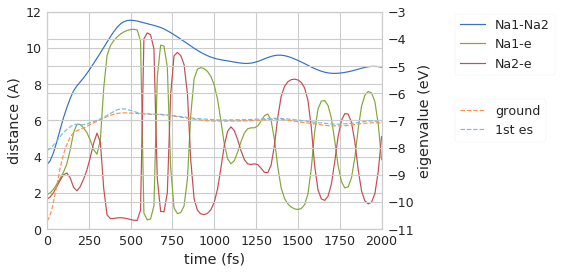

In [6]:
plt_lib.plotDistEigval(bond_dist_Ar_overlap, na_e_dist_Ar_overlap, eigvals_Ar_overlap, xlim=[0,2000])

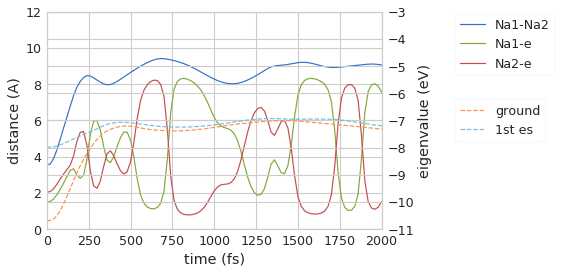

In [7]:
my_dir = '/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/first_es/max_overlap/2'
bond_dist_Ar_overlap, na_e_dist_Ar_overlap = lib.readDist(my_dir)
eigvals_Ar_overlap = lib.readEigval(my_dir, dt=4)
plt_lib.plotDistEigval(bond_dist_Ar_overlap, na_e_dist_Ar_overlap, eigvals_Ar_overlap, xlim=[0,2000])

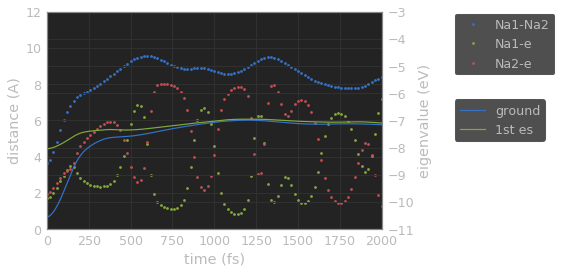

In [7]:
my_dir = 'first_es/max_overlap/3'
bond_dist_Ar_overlap, na_e_dist_Ar_overlap = lib.readDist(my_dir)
eigvals_Ar_overlap = lib.readEigval(my_dir, dt=4)
plt_lib.plotDistEigval(bond_dist_Ar_overlap, na_e_dist_Ar_overlap, eigvals_Ar_overlap, xlim=[0,2000])

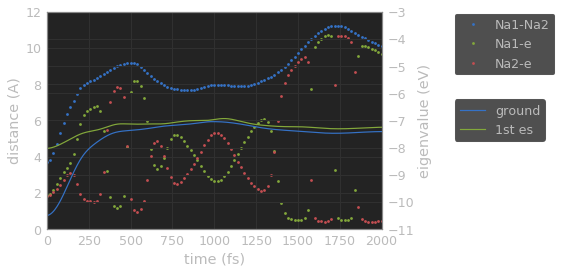

In [8]:
my_dir = 'first_es/max_overlap/4'
bond_dist_Ar_overlap, na_e_dist_Ar_overlap = lib.readDist(my_dir)
eigvals_Ar_overlap = lib.readEigval(my_dir, dt=4)
plt_lib.plotDistEigval(bond_dist_Ar_overlap, na_e_dist_Ar_overlap, eigvals_Ar_overlap, xlim=[0,2000])

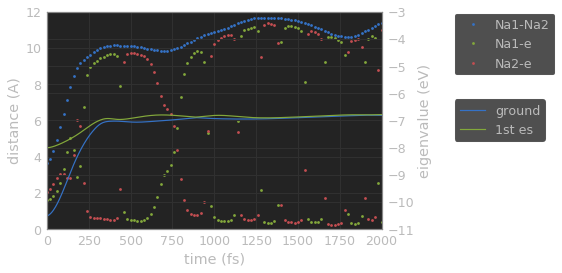

In [9]:
my_dir = 'first_es/max_overlap/5'
bond_dist_Ar_overlap, na_e_dist_Ar_overlap = lib.readDist(my_dir)
eigvals_Ar_overlap = lib.readEigval(my_dir, dt=4)
plt_lib.plotDistEigval(bond_dist_Ar_overlap, na_e_dist_Ar_overlap, eigvals_Ar_overlap, xlim=[0,2000])

Doesnt want to separate and remain on either Na1 or Na2 because electron always wants to stay on the sodium with more argons around it (and not a result of avoided crossing!). To show that it won't dissociate and that the fes and ground state dynamics are not equal despite them being degenerate, forcing electron to hop to ground state at 1000 fs

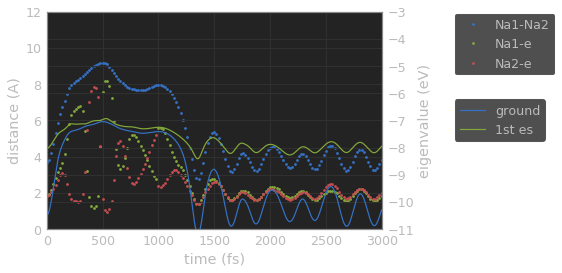

In [6]:
# If hop to ground state, will recombine
my_dir = 'first_es/max_overlap/hop2grnd/4_1000'
bond_dist_4_1000, na_e_dist_4_1000 = lib.readDist(my_dir)
eigvals_4_1000 = lib.readEigval(my_dir, dt=2)
bond_dist_4_1000[:,0] += 1000; na_e_dist_4_1000[:,0] += 1000; eigvals_4_1000[:,0] += 1000
array1 = np.append(bond_dist_Ar_overlap[:50], bond_dist_4_1000, axis=0)
array2 = np.append(na_e_dist_Ar_overlap[:50], na_e_dist_4_1000, axis=0)
array3 = np.append(eigvals_Ar_overlap[:500], eigvals_4_1000, axis=0)
plt_lib.plotDistEigval(array1, array2, array3, xlim=[0,3000])

### Umbrella sampling and PMFs


In [4]:
def plotHist(root, dirs, corr_time, r0, r1, dr):
    plt.figure(figsize=(20,11))
    hist_horz_axis = np.linspace(r0, r1, num=int((r1-r0)/dr+1))
    total_count = np.zeros(len(hist_horz_axis))
    for i in range(len(dirs)):
        data = np.loadtxt(root+dirs[i])[::corr_time[i],1]
        hist_vert_axis = np.zeros(len(hist_horz_axis))

        for j in data:
            if j < r0 or j > r1:
                continue
            bin_ind = int((j-r0)/dr)
            hist_vert_axis[bin_ind] += 1

        total_count += hist_vert_axis
        plt.plot(hist_horz_axis, hist_vert_axis, 'o-', label=dirs[i])
    plt.plot(hist_horz_axis, total_count, 'C0--')
    plt.ylim([0,150])
    plt.legend(loc=2)
    plt.xlim([3.0,9.0])
    
    plt.twinx()
    
#     for i in range(len(dirs)):
#         xs = np.arange(float(dirs[i])-0.2, float(dirs[i])+0.2, 0.02)
#         ys = 0.5*15.0/unitl*(xs-float(dirs[i]))**2*eVtokT
       
#         plt.plot(xs, ys, '^--', label=dirs[i])
    
#     plt.ylim([0,15])
#     plt.legend(loc=1)
    
    #plt.ylim([0])
    return None

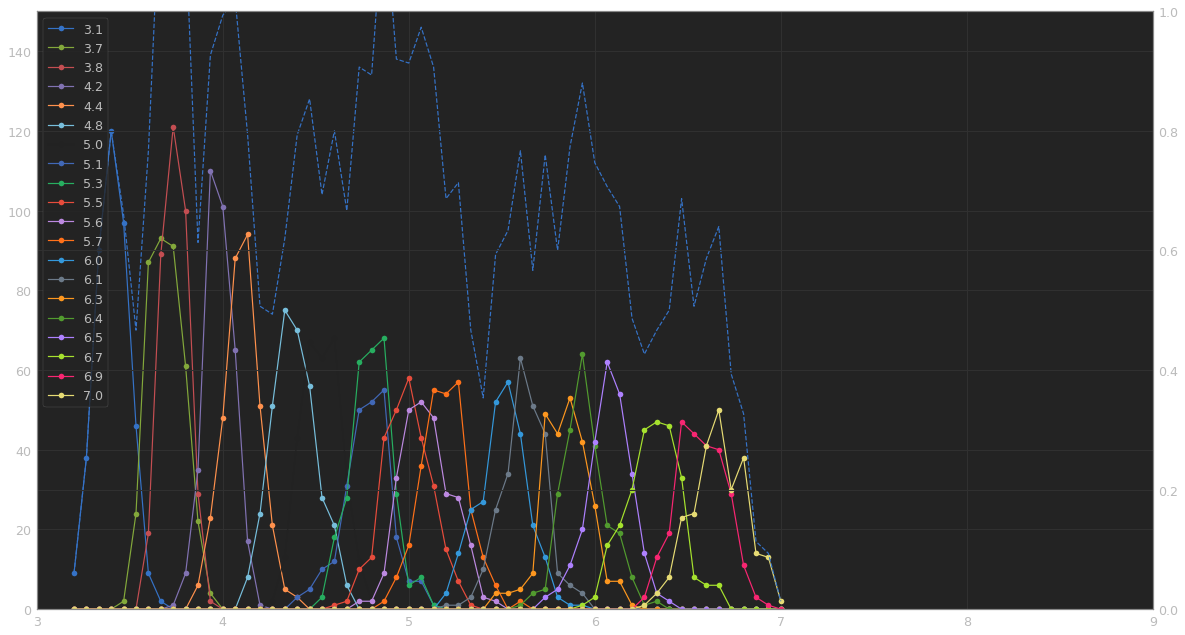

In [5]:
# Hist of ground state umbrella traj
root = '/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/bond_umb/data/'
dirs = '3.1  3.7  3.8  4.2  4.4  4.8  5.0  5.1  5.3  5.5  5.6  5.7  6.0  6.1  6.3  6.4  6.5  6.7  6.9  7.0'.split()
corr_time = [14, 15, 16, 17, 17, 17, 19, 23, 20, 21, 21, 21, 22, 23, 23, 24, 23, 22, 23, 23]
plotHist(root, dirs, corr_time, 3.2, 7.0, 0.066)

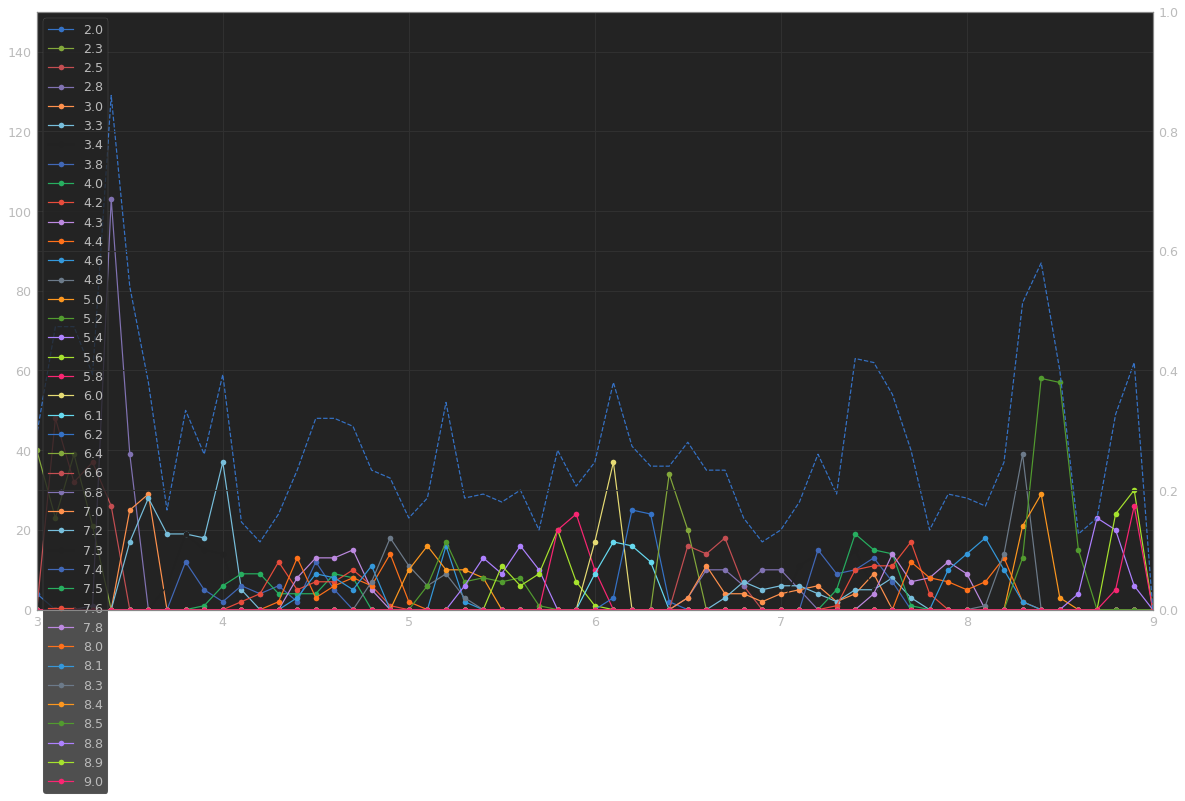

In [8]:
# Hist of excited state umbrella traj
root = '/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/bond_umb/fes/data/'
dirs = ['2.0', '2.3', '2.5', '2.8', '3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', 
        '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1',
        '6.2', '6.4', '6.6', '6.8', '7.0', '7.2', '7.3', '7.4', '7.5',
        '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
corr_time = 14*np.ones(len(dirs), dtype=int)
plotHist(root, dirs, corr_time, 2.8, 9.0, 0.1)

In [9]:
# Loading grd PMF
data = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/bond_umb/pmf.dat')
pmf_dat = {'bins':data[:,0],'f':data[:,1],'df':data[:,2],'p':data[:,3],'dp':data[:,4]}
del data

In [10]:
# Loading fes PMF
data = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/bond_umb/fes/pmf.dat')
fes_pmf_dat = {'bins':data[:,0],'f':data[:,1],'df':data[:,2],'p':data[:,3],'dp':data[:,4]}
del data

In [11]:
# Loading gas phase PES
pec_21 = np.zeros([len(np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]),6])
pec_21[:,0] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]
intra_nana_21 = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/out.energies_mf')[:,9]
for i in range(5):
    pec_21[:,i+1] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/out.quante'+str(i+1))[:,1] + intra_nana_21 + 4.884
pec_21 = pec_21[pec_21[:,0].argsort()]

In [12]:
# Loading direct sampling around eqb bond dist
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/equilibrate/'
bond_dat = lib.readDist(my_dir+'t19,88', n_solu=2, unitl=21.9166090280612)[0][::5,1]
bond_dat = np.append(bond_dat, np.loadtxt(my_dir+'moar/bondumb2.out')[::25,1])
bond_dat = np.append(bond_dat, np.loadtxt(my_dir+'moar/MOAR/bondumb2.out')[::25,1])
bond_dist = np.zeros([len(bond_dat),2])
bond_dist[:,0] = np.arange(len(bond_dat))*100
bond_dist[:,1] = bond_dat
boltz_pmf = sm.boltzPMF(bond_dist, 3.3, 4.2, 0.05)

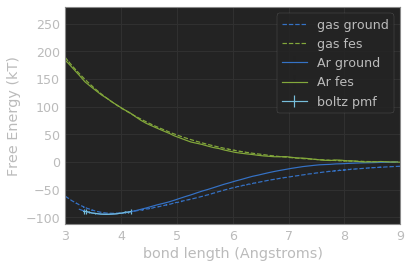

In [13]:
# Plotting PMFs and PES in kT
plt.errorbar(pmf_dat['bins'],pmf_dat['f']-max(pmf_dat['f']),yerr=pmf_dat['df'],ecolor='k',color='C0',label='Ar ground')
#plt.errorbar(pmf_dat2['bins'],pmf_dat2['f']-max(pmf_dat['f']),yerr=pmf_dat2['df'],ecolor='k',color='C3',label='more stats')
plt.errorbar(fes_pmf_dat['bins'],fes_pmf_dat['f'],yerr=fes_pmf_dat['df'],ecolor='k',color='C1',label='Ar fes')
plt.errorbar(boltz_pmf[:,0], boltz_pmf[:,1]-max(pmf_dat['f']), yerr=boltz_pmf[:,2], color='C5', label='boltz pmf')
plt.plot(pec_21[:,0],pec_21[:,1]*eVtokT,'C0--',label='gas ground')
plt.plot(pec_21[:,0],pec_21[:,2]*eVtokT,'C1--',label='gas fes')
plt.ylabel('Free Energy (kT)')
plt.xlabel('bond length (Angstroms)')
plt.xlim([3.0,9.0])
#plt.ylim([-50,0])
plt.legend(loc=1)

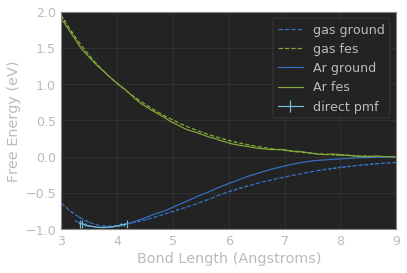

In [14]:
# Plotting PMFs and PES in eV
plt.errorbar(pmf_dat['bins'],(pmf_dat['f']-max(pmf_dat['f']))/eVtokT,yerr=pmf_dat['df']/eVtokT,ecolor='k',color='C0',label='Ar ground')
plt.errorbar(fes_pmf_dat['bins'],fes_pmf_dat['f']/eVtokT,yerr=fes_pmf_dat['df']/eVtokT,ecolor='k',color='C1',label='Ar fes')
plt.errorbar(boltz_pmf[:,0], (boltz_pmf[:,1]-max(pmf_dat['f']))/eVtokT, yerr=boltz_pmf[:,2]/eVtokT, color='C5', label='direct pmf')
plt.plot(pec_21[:,0],pec_21[:,1],'C0--',label='gas ground')
plt.plot(pec_21[:,0],pec_21[:,2],'C1--',label='gas fes')
plt.ylabel('Free Energy (eV)')
plt.xlabel('Bond Length (Angstroms)')
plt.xlim([3.0,9.0])
plt.ylim([-1,2])
#plt.yticks(np.arange(-8,14,2))
plt.legend(loc=1)

I see some concerning features in the fes pmf. Want to run more traj to see if this is an issue with averaging.  
Want to run more between 7.5-8.5 Ang, 6.5-7.25 Ang, 3.25-4.25 Ang, 

Now looking at FES-from-GRD and GRD-from-FES to look at linear response.

In [15]:
def eigvalBondDist(root, dirs):
    '''
    returns eigenvalues as function of bond distance. 
    Bond distance is sorted from small to large and is in first column of returned matrix
    '''
    eigvals = [[]]
    for i in range(len(dirs)):
        my_eigvals = lib.readEigval(root+dirs[i])[::5]
        my_bond = lib.readDist(root+dirs[i])[0][:,1]
        for j in range(len(my_eigvals)):
            eigvals += [[my_bond[j],my_eigvals[j,1],my_eigvals[j,2],my_eigvals[j,3],my_eigvals[j,4],my_eigvals[j,5]]]
    del eigvals[0]
    return np.sort(np.array(eigvals),axis=0)

In [16]:
# Getting eigenvalues as fxn of bond distance for each set of trajectories
eigval_21 = np.zeros([len(np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]),6])
eigval_21[:,0] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/bondumb2.out')[:,1]
for i in range(5):
    eigval_21[:,i+1] = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_gas/SPE9_21Ang/out.quante'+str(i+1))[:,1]
eigval_21.sort(axis=0)

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/'
dirs = '2.2  2.8  3.3  3.7  4.0  4.4  4.7  5.0  5.2  5.5  5.7  6.0  6.3  6.5  6.9  7.2  7.5  7.7  8.0  8.4  8.6  9.0  2.5  3.1  3.6  3.8  4.2  4.5  4.8  5.1  5.3  5.6  5.8  6.1  6.4  6.7  7.0  7.3  7.6  7.8  8.2  8.5  8.8'.split()
grnd_eigvals = eigvalBondDist(root, dirs)

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
dirs = ['2.0', '2.3', '2.5', '2.8', '3.0', '3.3', '3.4', '3.8', '4.0', '4.2', '4.3', '4.4', '4.6', 
        '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1',
        '6.2', '6.4', '6.6', '6.8', '7.0', '7.2', '7.3', '7.4', '7.5',
        '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
fes_eigvals = eigvalBondDist(root, dirs)

(3, 9)

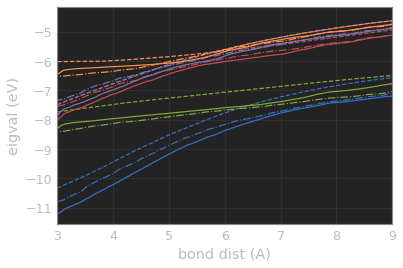

In [17]:
# Plotting eigenvalues as fxn of bond distance for each set of trajectories
for i in range(5):
    plt.plot(grnd_eigvals[:,0], grnd_eigvals[:,i+1])
    plt.plot(fes_eigvals[::150,0], fes_eigvals[::150,i+1], 'C'+str(i)+'-.')
    plt.plot(eigval_21[:,0], eigval_21[:,i+1], 'C'+str(i)+'--')
plt.xlabel('bond dist (A)')
plt.ylabel('eigval (eV)')
plt.xlim([3,9])

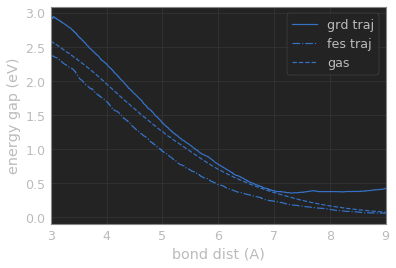

In [18]:
# Looking at energy gap (E_fes - E_grd) for grd, fes, and gas traj
for i in range(1):
    plt.plot(grnd_eigvals[:,0], grnd_eigvals[:,i+2]-grnd_eigvals[:,1], 'C'+str(i), label='grd traj')
    plt.plot(fes_eigvals[:,0], fes_eigvals[:,i+2]-fes_eigvals[:,1], 'C'+str(i)+'-.', label='fes traj')
    plt.plot(eigval_21[:,0], eigval_21[:,i+2]-eigval_21[:,1], 'C'+str(i)+'--', label='gas')
plt.ylabel('energy gap (eV)')
plt.xlabel('bond dist (A)')
plt.xlim([3,9])
plt.legend(loc=1)

Since eigvalues are smoothly varying with bond distance and with minimal noise, no need to bin and average.

Solid lines are eigvals from ground state traj and dashed lines are eigvals for excited state traj.

In [19]:
def findEigvals(eigvals, bond_length):
    '''
    Specific to this application. Eigvals should be shape Nx6 where first column is bond_length,
        and proceeding columns are eigvals for the lowest 5 energy states
    For a given bond_length, returns eigvals best associated with the given bond_length.
    Note that this not an efficient way of looking up a value, but 
        the more efficient method (take difference and sort) was working for some damn reason.
    '''
    if bond_length-eigvals[0,0] < -0.1 and bond_length-eigvals[-1,0] > 0.1:
        print('Given bond_length is not in eigvals matrix')
        return None
    for i in range(len(eigvals)):
        if eigvals[i,0] > bond_length:
            return eigvals[i,1:]
    return eigvals[-1,1:]

In [20]:
# Using eigvals to "predict" PMFs
predicted_fes = np.zeros(len(pmf_dat['f']))
for i in range(len(predicted_fes)):
    my_array = findEigvals(grnd_eigvals, pmf_dat['bins'][i])
    predicted_fes[i] = pmf_dat['f'][i]/eVtokT-my_array[0]+my_array[1]

predicted_grnd = np.zeros(len(fes_pmf_dat['f']))
for i in range(len(predicted_grnd)):
    my_array = findEigvals(fes_eigvals, fes_pmf_dat['bins'][i])
    predicted_grnd[i] = fes_pmf_dat['f'][i]/eVtokT-my_array[1]+my_array[0]

In [21]:
# Loading fes PMF
data = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/bond_umb/fes/pmf.dat')
fes_pmf_dat = {'bins':data[:,0],'f':data[:,1],'df':data[:,2],'p':data[:,3],'dp':data[:,4]}
del data

In [25]:
gnd_egap = lib.binScalarsBondDist(grnd_eigvals[:,2]-grnd_eigvals[:,1], grnd_eigvals[:,0], 3.2,9,0.1)

In [26]:
fes_egap = lib.binScalarsBondDist(fes_eigvals[:,2]-fes_eigvals[:,1], fes_eigvals[:,0], 2.8,9,0.1)

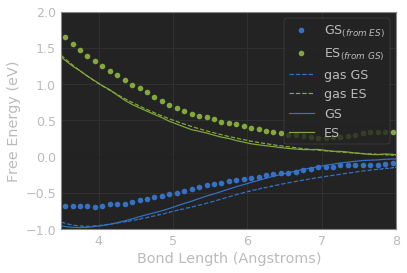

In [29]:
# Plotting everything together
plt.errorbar(pmf_dat['bins'],(pmf_dat['f']-max(pmf_dat['f']))/eVtokT,yerr=pmf_dat['df']/eVtokT,ecolor='k',color='C0',label='GS')
plt.plot(fes_pmf_dat['bins'], fes_pmf_dat['f']/eVtokT-fes_egap[:,1], 'C0o', label='GS$_{(from\ ES)}$')
plt.plot(pmf_dat['bins'], pmf_dat['f']/eVtokT+gnd_egap[:,1]-max(pmf_dat['f'])/eVtokT, 'C1o', label='ES$_{(from\ GS)}$')
plt.errorbar(fes_pmf_dat['bins'],fes_pmf_dat['f']/eVtokT,yerr=fes_pmf_dat['df']/eVtokT,ecolor='k',color='C1',label='ES')
plt.plot(pec_21[:,0],pec_21[:,1],'C0--',label='gas GS')
plt.plot(pec_21[:,0],pec_21[:,2],'C1--',label='gas ES')
plt.plot(np.arange(3,9,0.1),np.zeros(len(np.arange(3,9,0.1))),'k')

#plt.grid(False)
plt.ylabel('Free Energy (eV)')
plt.xlabel('Bond Length (Angstroms)')
plt.xlim([3.5,8])
plt.ylim([-1,2])
#plt.xlim([6.5,9])
#plt.ylim([-0.2,0.4])
#plt.yticks(np.arange(-1,3.5,0.5))
plt.tick_params('both', direction='out', bottom=True, top=True, right=True)
#plt.legend(loc='center left',bbox_to_anchor=(1.1,0.8))
plt.legend(loc=1, frameon=True)

Maybe the wiggles in the predicted pmfs come from errors in the eigval as fxn of distance, so I could smooth it out

blue circles represent predicted pmf from excited state traj and green circles represent predicted pmf from ground state traj

Note: Energy of 'ES' adjusted to match 'gas ES' at long distances

A few things jump out to me.  
$\Delta E ^{\text{grd}}$, which is the energy gap between the ground state pmf and the fes pmf from the ground state trajectory, is larger than $\Delta E^{\text{gas}}$ at both $r > 7$ Ang and $r<5$ Ang. $\Delta E^{\text{grd}}(r<5)$ isn't too concerning since it does roughly follow the same trend/curvature of $\Delta E^{\text{gas}}$ within error, but $\Delta E^\text{grd}(r>7)$ doesn't go to zero which is interesting.  
Next, the predicted grd state pmf from the fes traj doesnt follow the expected trend at $r<4$ Ang. 

For $\Delta E^\text{grd}(r>7)$, I want to look at $<d_\text{Na1-Ar}>$ and $<d_\text{Na2-Ar}>$ when run on the ground state and compare the same for fes traj

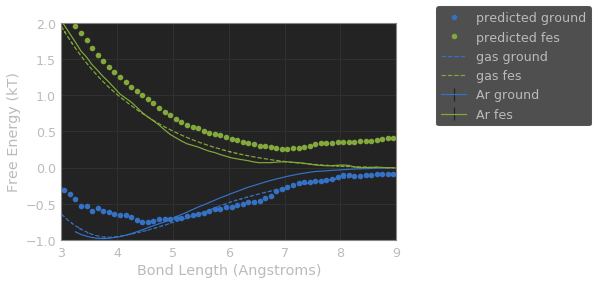

In [30]:
# Now recreating same plot above but after turning off solvent polarization (from presence of cation)
# to see if the interesting region below 4 Ang is from polarization
# Loading fes PMF
data = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/bond_umb/fes/nopol/pmf.dat')
nopol_fes_pmf_dat = {'bins':data[:,0],'f':data[:,1],'df':data[:,2],'p':data[:,3],'dp':data[:,4]}
del data

root = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/'
dirs = ['nopol/2.0', 'nopol/2.3', 'nopol/2.5', 'nopol/2.8', 'nopol/3.0', 'nopol/3.3',
        'nopol/3.4', 'nopol/3.8', 'nopol/4.0', 'nopol/4.2', '4.3', '4.4', '4.6', 
        '4.8', '5.0', '5.2', '5.4', '5.6', '5.8', '6.0', '6.1',
        '6.2', '6.4', '6.6', '6.8', '7.0', '7.2', '7.3', '7.4', '7.5',
        '7.6', '7.8', '8.0', '8.1', '8.3', '8.4', '8.5', '8.8', '8.9', '9.0']
nopol_fes_eigvals = eigvalBondDist(root, dirs)

nopol_predicted_grnd = np.zeros(len(nopol_fes_pmf_dat['f']))
for i in range(len(nopol_predicted_grnd)):
    my_array = findEigvals(nopol_fes_eigvals, nopol_fes_pmf_dat['bins'][i])*eVtokT
    nopol_predicted_grnd[i] = nopol_fes_pmf_dat['f'][i]-my_array[1]+my_array[0]
    
# Plotting everything with nopol data
plt.errorbar(pmf_dat['bins'],(pmf_dat['f']-max(pmf_dat['f']))/eVtokT,yerr=pmf_dat['df']/eVtokT,ecolor='k',color='C0',label='Ar ground')
#plt.plot(pmf_dat['bins'], pmf_dat['f']-15,color='C0',label='Ar ground')
#plt.plot(fes_pmf_dat['bins'],fes_pmf_dat['f']+max(pmf_dat['f'])-13,'C1-',mfc='none',label='Ar fes')
plt.plot(nopol_fes_pmf_dat['bins'], (nopol_predicted_grnd)/eVtokT, 'C0o', label='predicted ground')
#plt.plot(pmf_dat['bins'], predicted_fes-max(pmf_dat['f'])/eVtokT, 'C1o', label='predicted fes')
plt.plot(pmf_dat['bins'], predicted_fes-max(pmf_dat['f'])/eVtokT, 'C1o', label='predicted fes')
plt.errorbar(nopol_fes_pmf_dat['bins'],(nopol_fes_pmf_dat['f'])/eVtokT,yerr=nopol_fes_pmf_dat['df']/eVtokT,
             ecolor='k',color='C1',label='Ar fes')
plt.plot(pec_21[:,0],pec_21[:,1],'C0--',label='gas ground')
plt.plot(pec_21[:,0],pec_21[:,2],'C1--',label='gas fes')
plt.ylabel('Free Energy (kT)')
plt.xlabel('Bond Length (Angstroms)')
plt.xlim([3.0,9.0])
plt.ylim([-1,2])
plt.legend(loc='center left',bbox_to_anchor=(1.1,0.8))

Not sure I want to have this nopol graph anymore

Now comparing equilibrium dynamics (PMFs from either running on the ground state or from running on the excited state) to nonequilibrium dynamics.

With the nonequilibrium dynamics, dimer cation is excited to dissociative energetic state (first excited state) starting from an equilibrium ground state configuration. System then evolves using nonadiabatic dynamics

Generate nonequilibrium, dynamic energy surface by taking time-integral of work with respect to the sodium cations. See my JPC Lett paper from 2020 (Vong, Widmer, Schwartz)

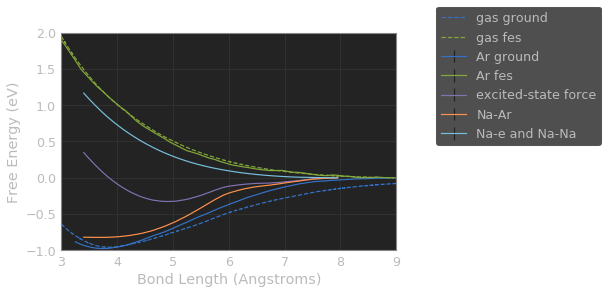

In [31]:
# Dissociative pmf from Na forces, from avg Force at bond distance, r
cp = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/first_es/fssh/unweighted_cp_v3.dat')
qp = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/first_es/fssh/unweighted_qp_v3.dat')
diss_pmf = qp + cp
nana_intra = (1.602e-19)/(4 * np.pi * 8.854e-22 * cp[:,0])

# Plotting PMFs and PES

plt.errorbar(pmf_dat['bins'],(pmf_dat['f']-max(pmf_dat['f']))/eVtokT,yerr=pmf_dat['df']/eVtokT,ecolor='k',color='C0',label='Ar ground')
plt.errorbar(fes_pmf_dat['bins'],fes_pmf_dat['f']/eVtokT,yerr=fes_pmf_dat['df']/eVtokT,ecolor='k',color='C1',label='Ar fes')

plt.errorbar(diss_pmf[:,0]/2,(diss_pmf[:,1]),yerr=diss_pmf[:,2],ecolor='k',color='C3',label='excited-state force')
plt.errorbar(cp[:,0], (cp[:,1]-nana_intra+1.8),yerr=cp[:,2],ecolor='k',color='C4', label='Na-Ar')
plt.errorbar(qp[:,0], (qp[:,1]+nana_intra-1.8),yerr=qp[:,2],ecolor='k',color='C5', label='Na-e and Na-Na')

plt.plot(pec_21[:,0],pec_21[:,1],'C0--',label='gas ground')
plt.plot(pec_21[:,0],pec_21[:,2],'C1--',label='gas fes')
plt.ylabel('Free Energy (eV)')
plt.xlabel('Bond Length (Angstroms)')
plt.xlim([3.0,9.0])
plt.ylim([-1,2])
plt.legend(loc='center left',bbox_to_anchor=(1.1,0.8))

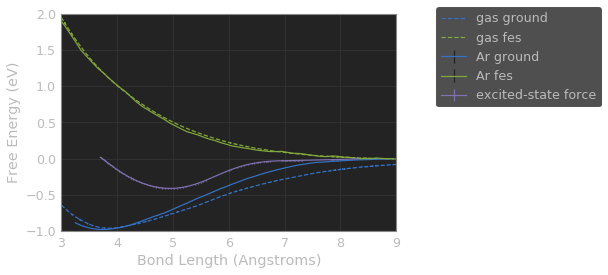

In [32]:
# Dissociative pmf from Na forces, from parameterizing Force-velocity and position against time
cp = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/first_es/fssh/unweighted_cp_v4.dat')
qp = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/first_es/fssh/unweighted_qp_v4.dat')
bond_dist = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/first_es/fssh/bond_dist.dat')
diss_pmf = qp + cp
nana_intra = (1.602e-19)/(4 * np.pi * 8.854e-22 * bond_dist[:,1])

# Plotting PMFs and PES
plt.errorbar(pmf_dat['bins'],(pmf_dat['f']-max(pmf_dat['f']))/eVtokT,yerr=pmf_dat['df']/eVtokT,ecolor='k',color='C0',label='Ar ground')
plt.errorbar(fes_pmf_dat['bins'],fes_pmf_dat['f']/eVtokT,yerr=fes_pmf_dat['df']/eVtokT,ecolor='k',color='C1',label='Ar fes')

plt.errorbar(bond_dist[:,1], diss_pmf[:,1], yerr=np.sqrt(cp[:,2]**2+qp[:,2]**2), color='C3',label='excited-state force')
#plt.plot(bond_dist[:,1], (cp[:,1]-nana_intra+1.8), 'C4', label='Na-Ar')
#plt.plot(bond_dist[:,1], (qp[:,1]+nana_intra-1.8), 'C5', label='Na-e and Na-Na')

plt.plot(pec_21[:,0],pec_21[:,1],'C0--',label='gas ground')
plt.plot(pec_21[:,0],pec_21[:,2],'C1--',label='gas fes')

plt.ylabel('Free Energy (eV)')
plt.xlabel('Bond Length (Angstroms)')
plt.xlim([3.0,9.0])
plt.ylim([-1,2])
#plt.yticks(np.arange(-8,14,2))
plt.legend(loc='center left',bbox_to_anchor=(1.1,0.8))

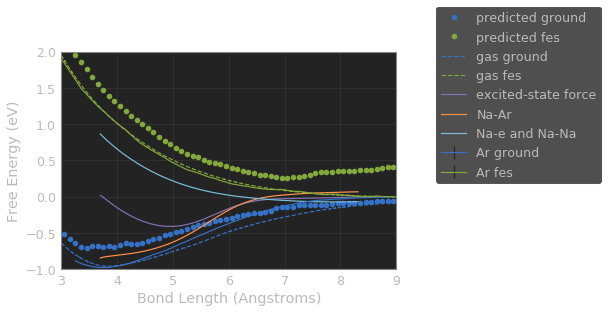

In [34]:
# Dynamic pmf with LR predictions
plt.errorbar(pmf_dat['bins'],(pmf_dat['f']-max(pmf_dat['f']))/eVtokT,yerr=pmf_dat['df']/eVtokT,ecolor='k',color='C0',label='Ar ground')
plt.plot(fes_pmf_dat['bins'], predicted_grnd, 'C0o', label='predicted ground')
plt.plot(pmf_dat['bins'], predicted_fes-max(pmf_dat['f'])/eVtokT, 'C1o', label='predicted fes')
plt.errorbar(fes_pmf_dat['bins'],fes_pmf_dat['f']/eVtokT,yerr=fes_pmf_dat['df']/eVtokT,ecolor='k',color='C1',label='Ar fes')
plt.plot(pec_21[:,0],pec_21[:,1],'C0--',label='gas ground')
plt.plot(pec_21[:,0],pec_21[:,2],'C1--',label='gas fes')

plt.plot(bond_dist[:,1], diss_pmf[:,1],'C3',label='excited-state force')
plt.plot(bond_dist[:,1], (cp[:,1]-nana_intra+1.8), 'C4', label='Na-Ar')
plt.plot(bond_dist[:,1], (qp[:,1]+nana_intra-1.8), 'C5', label='Na-e and Na-Na')

plt.ylabel('Free Energy (eV)')
plt.xlabel('Bond Length (Angstroms)')
plt.xlim([3.0,9.0])
plt.ylim([-1,2])
#plt.yticks(np.arange(-8,14,2))
plt.legend(loc='center left',bbox_to_anchor=(1.1,0.8))

Q: Why do the 'Na-e and Na-Na' and 'Ar fes' look so similar? (lines are formed by extracting Na-e and Na-Na interactions during a non-equilibrium run and by running at equilibrium on fes using umbrella sampling, respectively) 

Guess: The electron density does not fluctutate very much and Na-Na distance doesnt fluctuate either. Therefore, by extracting the solvent interactions from dynamical pmf, we have removed fluctuations. The same effect is performed by using umbrella sampling. 

To support this, I can calculate the $<\psi (r)>$ from the umrella run, then dot it with $\psi(r)_{non-eq}$. If the dot product is nearly 1 for all distances, then says that the electron does run as if system is at equilibrium at all times, which is what LR would predict. 

--> In order to calculate $<\psi(r)>$ would want to show that $\psi(r)_{eq}$ does not fluctuate much, which I can do with auto-correlation. 

Text(0.5,0,'Bond Length (Angstroms)')

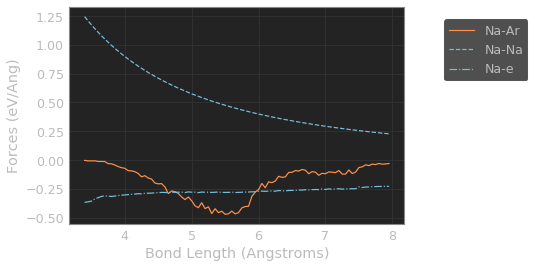

In [35]:
# Looking at dissociative forces
cf = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/first_es/fssh/unweighted_cf_v3.dat')
qf = np.loadtxt('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/first_es/fssh/unweighted_qf_v3.dat')
nana_intra = (1.602e-19)/(4 * np.pi * 8.854e-22 * cf[:,0] * cf[:,0])

plt.plot(cf[:,0], (cf[:,1]-nana_intra),'C4', label='Na-Ar')
plt.plot(cf[:,0], (nana_intra),'C5--', label='Na-Na')
plt.plot(qf[:,0], qf[:,1],'C5-.', label='Na-e')
plt.legend(loc='center left',bbox_to_anchor=(1.1,0.8))
plt.ylabel('Forces (eV/Ang)')
plt.xlabel('Bond Length (Angstroms)')

### Finding snapshots for publication

In [ ]:
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/first_es/fssh/2/1/'
t0 = 60; t = 400; dt = 20; N = 4; Ar_metric = 'dimer'
vacant, occupied, r_Na, close, closest, verts, faces = dictShellPts(my_dir, t0, t, dt, N, Ar_metric, dens_file='rho_st2.cube')

In [ ]:
# With BoundedIntText widget
t_frames = np.linspace(t0,t,num=int((t-t0)/dt+1),dtype='int')
my_Na = r_Na[str(t_frames[0])]
my_vacant = vacant[str(t_frames[0])]; my_occupied = occupied[str(t_frames[0])]
my_close = close[str(t_frames[0])]; my_closest = closest[str(t_frames[0])]
my_verts = verts[str(t_frames[0])]; my_faces = faces[str(t_frames[0])]

fig = ipv.figure()

ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')
ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#00ff00C1')
#ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#1f77b4')

ipv.xyzlim(-9,9)
ipv.show()

a=widgets.BoundedIntText(value=t0, min=t0, max=t, step=dt, description='Time (fs):')
def f(x):
    my_Na = r_Na[str(x)]
    my_vacant = vacant[str(x)]; my_occupied = occupied[str(x)]
    my_close = close[str(x)]; my_closest = closest[str(x)]
    my_verts = verts[str(x)]; my_faces = faces[str(x)]
    fig.scatters.clear()
    fig.meshes.clear()
    
    ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
    ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
    ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
    ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
    ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')
    ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#00ff00C1')
#    ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#1f77b4')
    
    ipv.xyzlim(-9,9)
    
w = widgets.interact(f, x=a)

In [ ]:
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/6.0/'
t0 = 2980; t = 3020; dt = 20; N = 2; Ar_metric = 'cation'
vacant, occupied, r_Na, close, closest, verts, faces = dictShellPts(my_dir, t0, t, dt, N, Ar_metric, dens_file='rho_st1.cube')

In [ ]:
# With BoundedIntText widget
t_frames = np.linspace(t0,t,num=int((t-t0)/dt+1),dtype='int')
my_Na = r_Na[str(t_frames[0])]
my_vacant = vacant[str(t_frames[0])]; my_occupied = occupied[str(t_frames[0])]
my_close = close[str(t_frames[0])]; my_closest = closest[str(t_frames[0])]
my_verts = verts[str(t_frames[0])]; my_faces = faces[str(t_frames[0])]

fig = ipv.figure()

ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')
ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#00ff00C1')
#ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#1f77b4')

ipv.xyzlim(-9,9)
ipv.show()

a=widgets.BoundedIntText(value=t0, min=t0, max=t, step=dt, description='Time (fs):')
def f(x):
    my_Na = r_Na[str(x)]
    my_vacant = vacant[str(x)]; my_occupied = occupied[str(x)]
    my_close = close[str(x)]; my_closest = closest[str(x)]
    my_verts = verts[str(x)]; my_faces = faces[str(x)]
    fig.scatters.clear()
    fig.meshes.clear()
    
    ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
    ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
    ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
    ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
    ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')
    ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#00ff00C1')
#    ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#1f77b4')
    
    ipv.xyzlim(-9,9)
    
w = widgets.interact(f, x=a)

In [11]:
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/fes/rigid/5.4/'
t0 = 3000; t = 3500; dt = 20; N = 2; Ar_metric = 'cation'
vacant, occupied, r_Na, close, closest, verts, faces = dictShellPts(my_dir, t0, t, dt, N, Ar_metric, dens_file='rho_st2.cube')

In [12]:
# With BoundedIntText widget
t_frames = np.linspace(t0,t,num=int((t-t0)/dt+1),dtype='int')
my_Na = r_Na[str(t_frames[0])]
my_vacant = vacant[str(t_frames[0])]; my_occupied = occupied[str(t_frames[0])]
my_close = close[str(t_frames[0])]; my_closest = closest[str(t_frames[0])]
my_verts = verts[str(t_frames[0])]; my_faces = faces[str(t_frames[0])]

fig = ipv.figure()

ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')
ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#00ff00C1')
#ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#1f77b4')

ipv.xyzlim(-9,9)
ipv.show()

a=widgets.BoundedIntText(value=t0, min=t0, max=t, step=dt, description='Time (fs):')
def f(x):
    my_Na = r_Na[str(x)]
    my_vacant = vacant[str(x)]; my_occupied = occupied[str(x)]
    my_close = close[str(x)]; my_closest = closest[str(x)]
    my_verts = verts[str(x)]; my_faces = faces[str(x)]
    fig.scatters.clear()
    fig.meshes.clear()
    
    ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
    ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
    ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
    ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
    ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')
    ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#00ff00C1')
#    ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#1f77b4')
    
    ipv.xyzlim(-9,9)
    
w = widgets.interact(f, x=a)

interactive(children=(BoundedIntText(value=3000, description='Time (fs):', max=3500, min=3000, step=20), Outpu…

In [15]:
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_Ar/bond_umb/rigid/7.0/'
t0 = 3000; t = 3500; dt = 20; N = 2; Ar_metric = 'cation'
vacant, occupied, r_Na, close, closest, verts, faces = dictShellPts(my_dir, t0, t, dt, N, Ar_metric, dens_file='rho_st1.cube')

In [16]:
# With BoundedIntText widget
t_frames = np.linspace(t0,t,num=int((t-t0)/dt+1),dtype='int')
my_Na = r_Na[str(t_frames[0])]
my_vacant = vacant[str(t_frames[0])]; my_occupied = occupied[str(t_frames[0])]
my_close = close[str(t_frames[0])]; my_closest = closest[str(t_frames[0])]
my_verts = verts[str(t_frames[0])]; my_faces = faces[str(t_frames[0])]

fig = ipv.figure()

ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')
ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#00ff00C1')
#ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#1f77b4')

ipv.xyzlim(-9,9)
ipv.show()

a=widgets.BoundedIntText(value=t0, min=t0, max=t, step=dt, description='Time (fs):')
def f(x):
    my_Na = r_Na[str(x)]
    my_vacant = vacant[str(x)]; my_occupied = occupied[str(x)]
    my_close = close[str(x)]; my_closest = closest[str(x)]
    my_verts = verts[str(x)]; my_faces = faces[str(x)]
    fig.scatters.clear()
    fig.meshes.clear()
    
    ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=5, color='#000000', marker='circle_2d')
    ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=0.5 ,color='#1f77b4', marker='circle_2d')
    ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=0.5, color='red', marker='circle_2d')
    ipv.scatter(my_close[:,0], my_close[:,1], my_close[:,2], size=2, color='green', marker='circle_2d')
    ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=2, color='red', marker='circle_2d')
    ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#00ff00C1')
#    ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#1f77b4')
    
    ipv.xyzlim(-9,9)
    
w = widgets.interact(f, x=a)

interactive(children=(BoundedIntText(value=3000, description='Time (fs):', max=3500, min=3000, step=20), Outpu…